In [83]:
import numpy as np      
# Backend tensorflow.compat.v1 or tensorflow
import scipy
import h5py
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.io
from scipy import ndimage
from scipy.spatial import KDTree
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def find_nearest1d(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [4]:
def find_nearest2d(array, value):
    array = np.asarray(array)
    idx   = np.zeros((np.size(value)))
    for j in range(0,np.size(value)):
        idx[j] = (np.abs(array - value[j])).argmin()
    return idx

In [173]:
with open('../JetP2a/JetCopy.dat', 'r') as f:
    a = np.array([float(field) for field in f.read().split()])

N  = 241*141
Xg  = a[0:1*N]
Xfull  = np.reshape(Xg,(241, 141),order='F').T
Yg  = a[1*N:2*N]
Yfull  = np.reshape(Yg,(241, 141),order='F').T
Ug  = a[2*N:3*N]
Ufull  = np.reshape(Ug,(241, 141),order='F').T
Vg  = a[3*N:4*N]
Vfull  = np.reshape(Vg,(241, 141),order='F').T
Wg  = a[4*N:5*N]
Wfull  = np.reshape(Wg,(241, 141),order='F').T
uug = a[5*N:6*N]
uufull = np.reshape(uug,(241, 141),order='F').T
vvg = a[6*N:7*N]
vvfull = np.reshape(vvg,(241, 141),order='F').T
wwg = a[7*N:8*N]
wwfull = np.reshape(wwg,(241, 141),order='F').T
uvg = a[8*N:9*N]
uvfull = np.reshape(uvg,(241, 141),order='F').T
uwg = a[9*N:10*N]
uwfull = np.reshape(uwg,(241, 141),order='F').T
vwg = a[10*N:11*N]
vwfull = np.reshape(vwg,(241, 141),order='F').T

In [184]:
## Taking only the upper portion of the axisymmetric data

Xr = Xfull[70:-1,:]
Yr = Yfull[70:-1,:]
Ur = Ufull[70:-1,:]
Vr = Vfull[70:-1,:]
Wr = Wfull[70:-1,:]
uur = uufull[70:-1,:]
vvr = vvfull[70:-1,:]
wwr = wwfull[70:-1,:]
uvr = uvfull[70:-1,:]
uwr = uwfull[70:-1,:]
vwr = vwfull[70:-1,:]

## Centerline jet velocity
Uo = Ur[0,:191]

X  = Xr[4:,:191]
Y  = Yr[4:,:191]
U  = Ur[4:,:191]
V  = Vr[4:,:191]
W  = Wr[4:,:191]
uu = uur[4:,:191]
vv = vvr[4:,:191]
ww = wwr[4:,:191]
uv = uvr[4:,:191]
uw = uwr[4:,:191]
vw = vwr[4:,:191]

In [185]:
Xgrid = X
Ygrid = Y

X_star = np.hstack((Xgrid.flatten()[:,None], Ygrid.flatten()[:,None]))

xmin = np.min(X_star[:,0:1])
xmax = np.max(X_star[:,0:1])

ymin = np.min(X_star[:,1:2])
ymax = np.max(X_star[:,1:2])

Xgrid   = np.single(X[:,:])
Ygrid   = np.single(Y[:,:])

x_coor = np.single(X[0,:]) 
y_coor = np.single(Y[:,0])


Uinf     = 1
L        = 1
nu       = 1/5601
Re       = Uinf*L/nu

Ustar    = U.flatten()[:,None]
Vstar    = V.flatten()[:,None]
uustar   = uu.flatten()[:,None]
vvstar   = vv.flatten()[:,None]
wwstar   = ww.flatten()[:,None]
uvstar   = uv.flatten()[:,None]

print('Min and max of U ',  np.amin(U), np.amax(U))
print('Min and max of V ',  np.amin(V), np.amax(V))
print('Min and max of uu ', np.amin(uustar), np.amax(uustar))
print('Min and max of vv ', np.amin(vvstar), np.amax(vvstar))
print('Min and max of uv ', np.amin(uvstar), np.amax(uvstar))
print('Min and max of ww ', np.amin(wwstar), np.amax(wwstar))

Min and max of U  0.009607000276 1.0
Min and max of V  -0.01161000039 0.02098999918
Min and max of uu  6.202999793e-05 0.0252299998
Min and max of vv  7.288000052e-05 0.01023999974
Min and max of uv  -3.534999905e-06 0.008426999673
Min and max of ww  0.0001810999966 0.01420000009


In [186]:
yfine = np.linspace(np.amin(Yr[:,1]), np.amax(Yr[:,1]), 256)
HalfWidth = np.zeros((np.shape(Uo)))

for i in range(0,np.size(U,1)):
    Ucenterline = Uo[i]
    Uaux = Ur[:,i]
    fU     = interp1d(Yr[:,0], Uaux, kind='cubic')
    Upred  = fU(yfine)
    j, yloc = find_nearest1d(Upred, 0.5*Ucenterline)
    HalfWidth[i] = yfine[yloc]

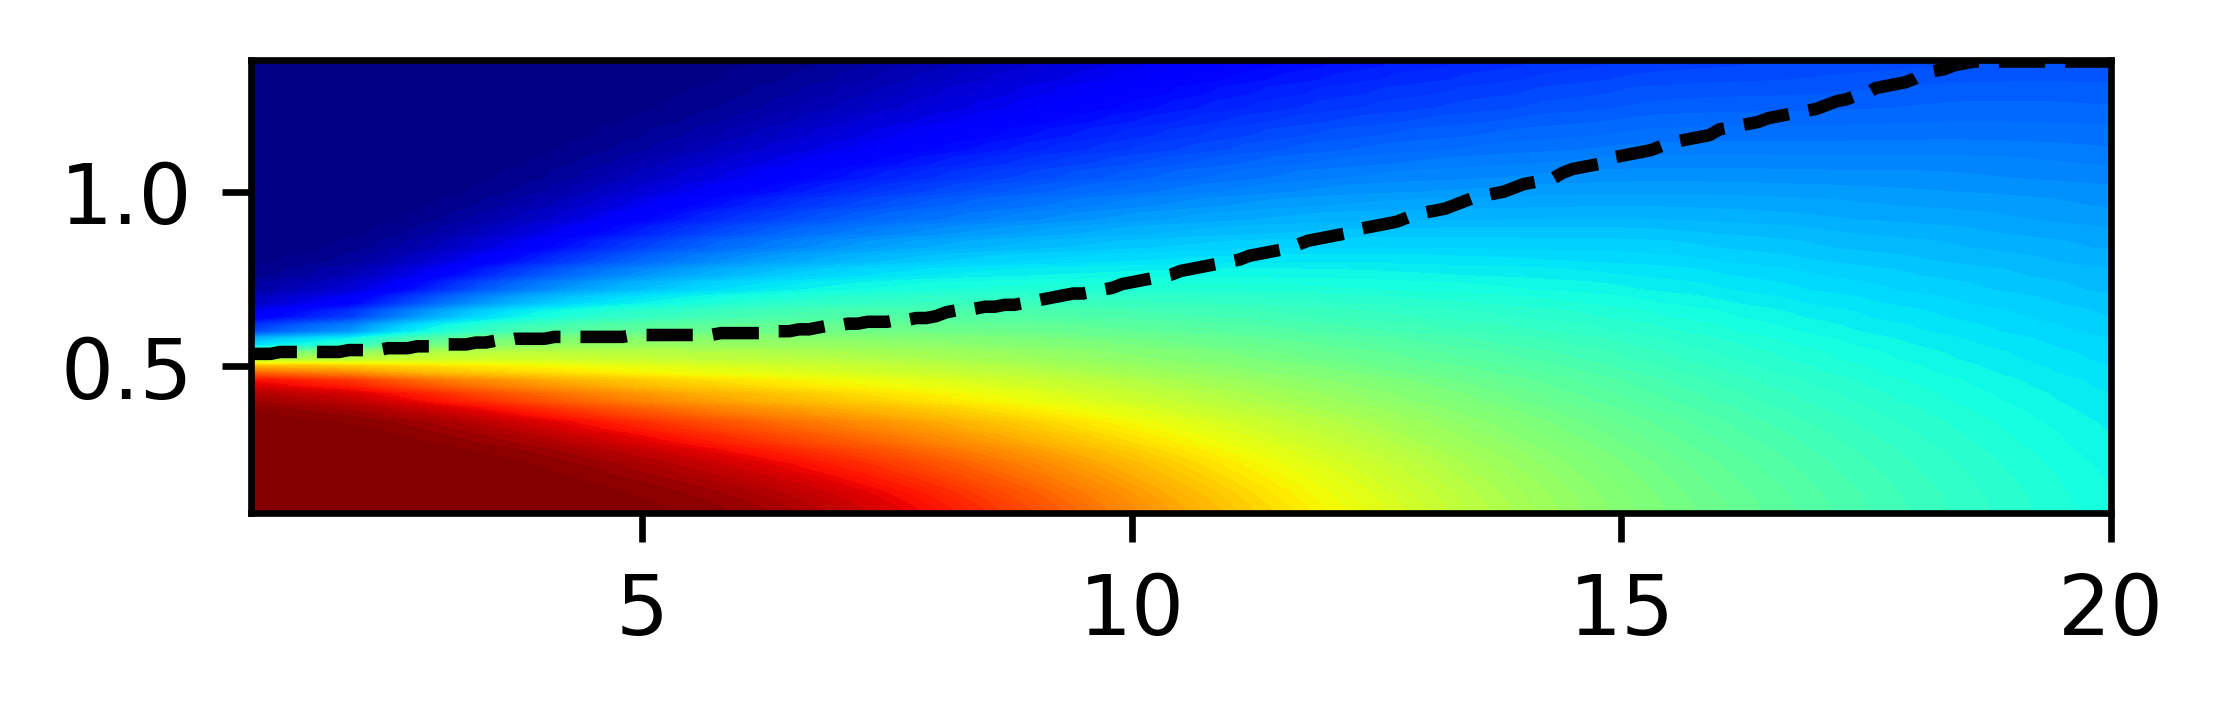

In [188]:
fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax = fig.add_subplot(2, 1, 1)
lvls = np.linspace(np.min(U),np.max(U),100)
cs0 = ax.contourf(Xgrid, Ygrid, U, levels=lvls, cmap='jet', extend = 'both')
cs1 = plt.plot(X[0,:], HalfWidth, 'k--')
# ax0.set_aspect("equal")

In [190]:
dx = 0.10
dy = 0.02

nut = HalfWidth*Uo/100

dUdx = np.zeros((np.size(U,0), np.size(U,1)))
for i in range(0, np.size(U,0)):
    f = U[i,:]
    dUdx[i,:] = np.gradient(f,dx)
    
dVdr = np.zeros((np.size(U,0), np.size(U,1)))    
for j in range(0, np.size(U,1)):
    g = V[:,j]
    dVdr[:,j] = np.gradient(g,dy) 
    
dVdx = np.zeros((np.size(U,0), np.size(U,1)))
for i in range(0, np.size(U,0)):
    f = V[i,:]
    dVdx[i,:] = np.gradient(f,dx)
    
dUdr = np.zeros((np.size(U,0), np.size(U,1)))    
for j in range(0, np.size(U,1)):
    g = U[:,j]
    dUdr[:,j] = np.gradient(g,dy)    

V_r = np.zeros((np.size(U,0), np.size(U,1)))    
for j in range(0, np.size(U,1)):
    V_r[:,j] = V[:,j]/Y[:,5]

uvModel = -nut*(dUdr + dVdx) 
uuModel = (2/3)*(uu+vv+ww) - 2*nut*(dUdx)
vvModel = (2/3)*(uu+vv+ww) - 2*nut*(dVdr)
wwModel = (2/3)*(uu+vv+ww) - 2*nut*(V_r)

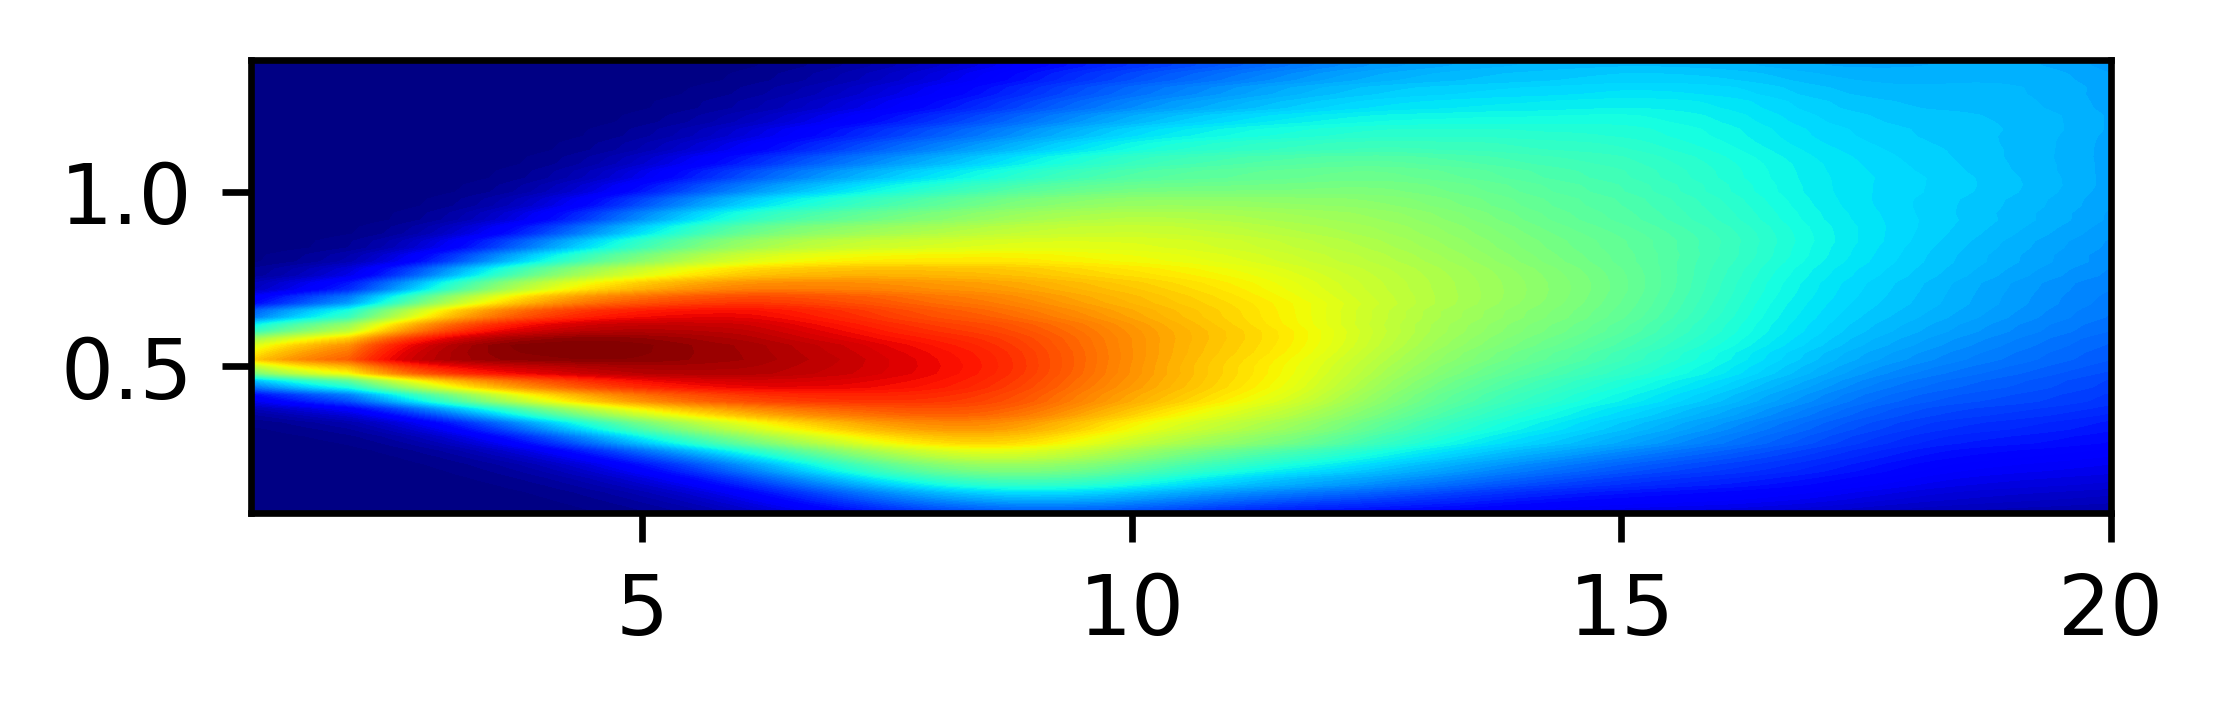

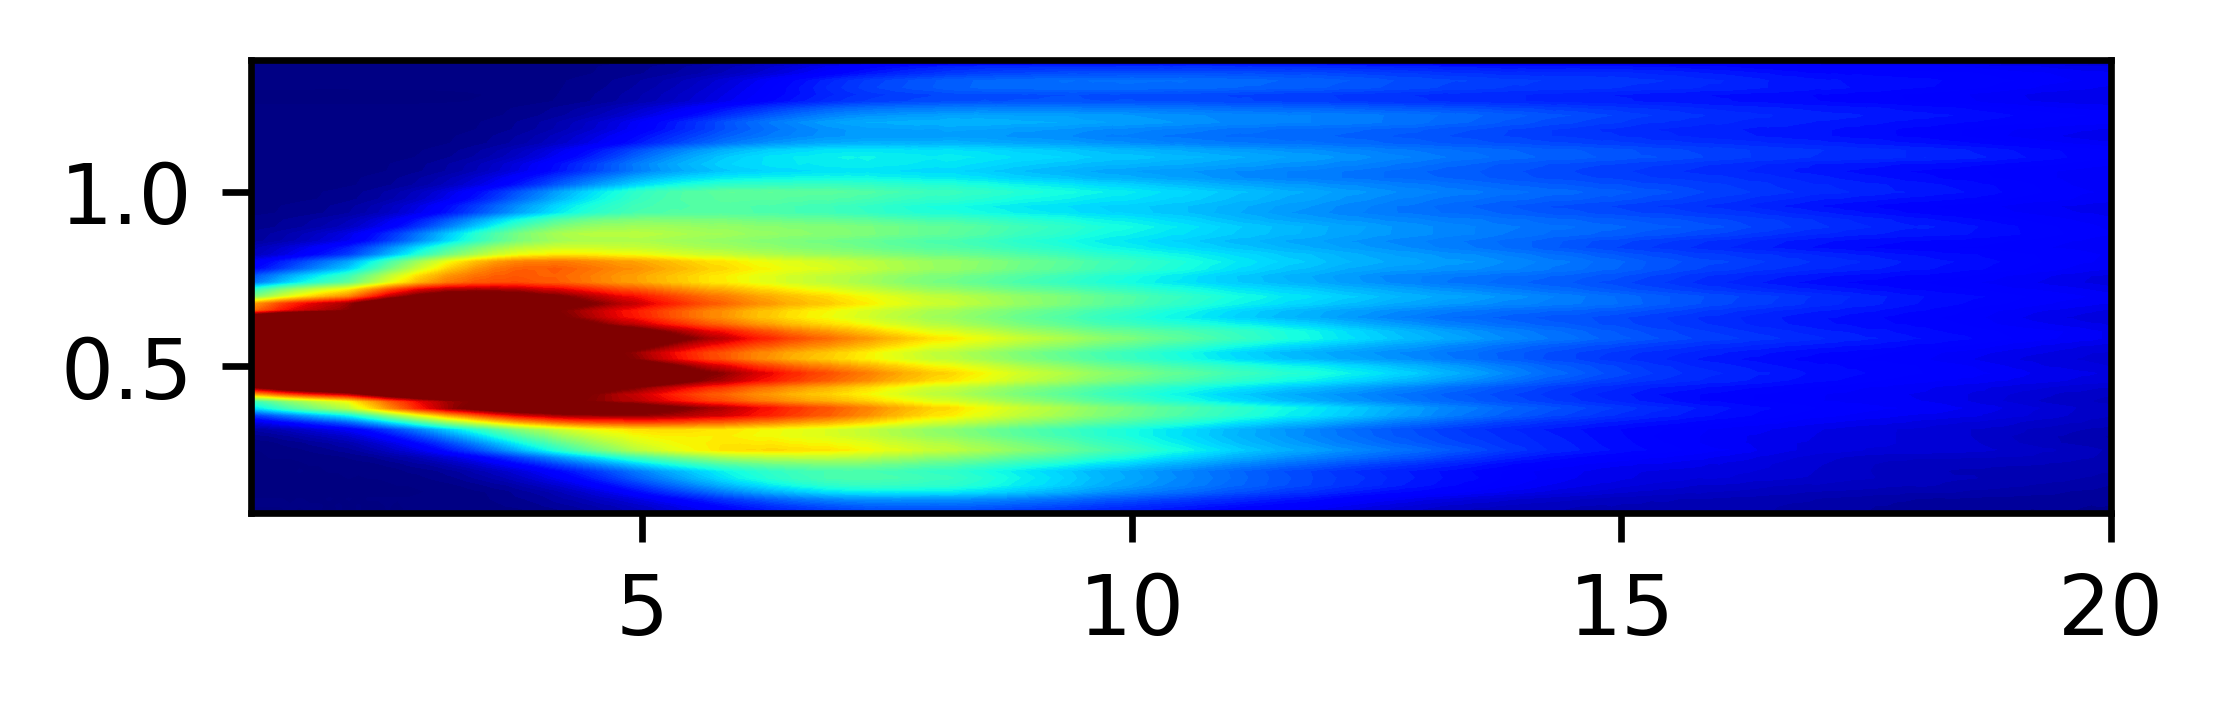

In [194]:
fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax = fig.add_subplot(2, 1, 1)
lvls = np.linspace(np.min(uv),np.max(uv),100)
cs0 = ax.contourf(Xgrid, Ygrid, uv, levels=lvls, cmap='jet', extend = 'both')

fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax = fig.add_subplot(2, 1, 1)
lvls = np.linspace(np.min(uv),np.max(uv),100)
cs0 = ax.contourf(Xgrid, Ygrid, uvModel, levels=lvls, cmap='jet', extend = 'both')

In [158]:
uuModel.shape

(66, 241)